In [1]:
import numpy as np
import torch
import torchvision as tv
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5,), (0.5,)),
])

trainset = tv.datasets.MNIST('./data', download=True, transform=transform, train=True)
valset = tv.datasets.MNIST('./data', download=True, transform=transform, train=False)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


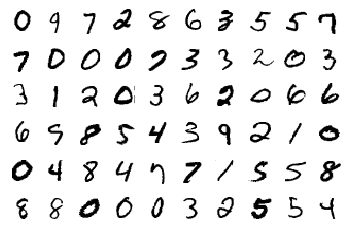

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [7]:
input_size = 28*28
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
).to(device)

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


In [11]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1).to(device)
labels = labels.to(device)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [12]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
tensor([[-0.0065, -0.0065, -0.0065,  ..., -0.0065, -0.0065, -0.0065],
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004],
        [-0.0009, -0.0009, -0.0009,  ..., -0.0009, -0.0009, -0.0009],
        ...,
        [ 0.0026,  0.0026,  0.0026,  ...,  0.0026,  0.0026,  0.0026],
        [-0.0065, -0.0065, -0.0065,  ..., -0.0065, -0.0065, -0.0065],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002]],
       device='cuda:0')


In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.to(device).view(images.shape[0], -1)
        labels = labels.to(device)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.14171891618194357
Epoch 1 - Training loss: 0.12233338082856587
Epoch 2 - Training loss: 0.1078151618239722
Epoch 3 - Training loss: 0.09593597238363107
Epoch 4 - Training loss: 0.08656749473626553
Epoch 5 - Training loss: 0.07806220732089172
Epoch 6 - Training loss: 0.0708103650239612
Epoch 7 - Training loss: 0.06474596976455468
Epoch 8 - Training loss: 0.06087499852580175
Epoch 9 - Training loss: 0.055657353347489065
Epoch 10 - Training loss: 0.05125806015580575
Epoch 11 - Training loss: 0.04887186818873323
Epoch 12 - Training loss: 0.04481604915739758
Epoch 13 - Training loss: 0.04067341672745087
Epoch 14 - Training loss: 0.038906690039074245

Training Time (in minutes) = 3.9768986543019613


In [17]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784).to(device)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps).to('cpu')
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9763


In [19]:
torch.save(model, './models/mnist_model.pt')